In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Achat.csv to Achat.csv
Saving Dim_Clients.csv to Dim_Clients.csv
Saving Dim_Temps.csv to Dim_Temps.csv
Saving Fait_Reservations.csv to Fait_Reservations.csv


In [5]:
df_faitAchat = pd.read_csv('Achat.csv', encoding='ISO-8859-1')

In [6]:
df_clients = pd.read_csv('Dim_Clients.csv', encoding='ISO-8859-1')

In [7]:
df_temps = pd.read_csv('Dim_Temps.csv', encoding='ISO-8859-1')

In [8]:
df_faitReservation = pd.read_csv('Fait_Reservations.csv', encoding='ISO-8859-1')

In [9]:
# 2. Préparation des données agrégées (indicateurs par client)
# -- Montant total des achats, nombre d’achats
achat_stats = df_faitAchat.groupby('Client_FK').agg(
    montant_total_achat=pd.NamedAgg(column='Prix_Total', aggfunc='sum'),
    nb_achats=pd.NamedAgg(column='AchatID_PK', aggfunc='count')
).reset_index()

In [10]:
# -- Statistiques de réservation
reservation_stats = df_faitReservation.groupby('ClientID_FK').agg(
    montant_total_reservation=pd.NamedAgg(column='Total_Prix', aggfunc='sum'),
    nb_reservations=pd.NamedAgg(column='Reservation_PK', aggfunc='count'),
    note_moyenne=pd.NamedAgg(column='Note_Client', aggfunc='mean')
).reset_index()

In [11]:
# -- Nombre de jours de voyage si Dates disponibles (on suppose que c'est la même date aller-retour, juste pour exemple)
df_faitReservation = df_faitReservation.merge(df_temps, left_on='Temps_FK', right_on='TempsID')
voyage_stats = df_faitReservation.groupby('ClientID_FK').agg(
    nb_jours_voyage=pd.NamedAgg(column='Date_Complète', aggfunc='nunique')  # approximation
).reset_index()

In [12]:
# 3. Fusionner les statistiques
df_final = achat_stats.merge(reservation_stats, left_on='Client_FK', right_on='ClientID_FK', how='outer')
df_final = df_final.merge(voyage_stats, on='ClientID_FK', how='left')

In [13]:
# 4. Remplir les NaN (0 si aucune réservation ou achat)
df_final.fillna(0, inplace=True)

In [14]:
# 5. Sélection des variables explicatives
features = ['montant_total_achat', 'nb_achats', 'montant_total_reservation',
            'nb_reservations', 'note_moyenne', 'nb_jours_voyage']
X = df_final[features]


In [15]:
# 6. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
# 7. KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_scaled)

In [17]:
# 8. Visualisation avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [18]:
df_final['pca1'] = X_pca[:, 0]
df_final['pca2'] = X_pca[:, 1]

pca1 =  axe global d'activité économique du client
pca2 = axe qui represente la satisfaction du client ou le comportement de voyage  

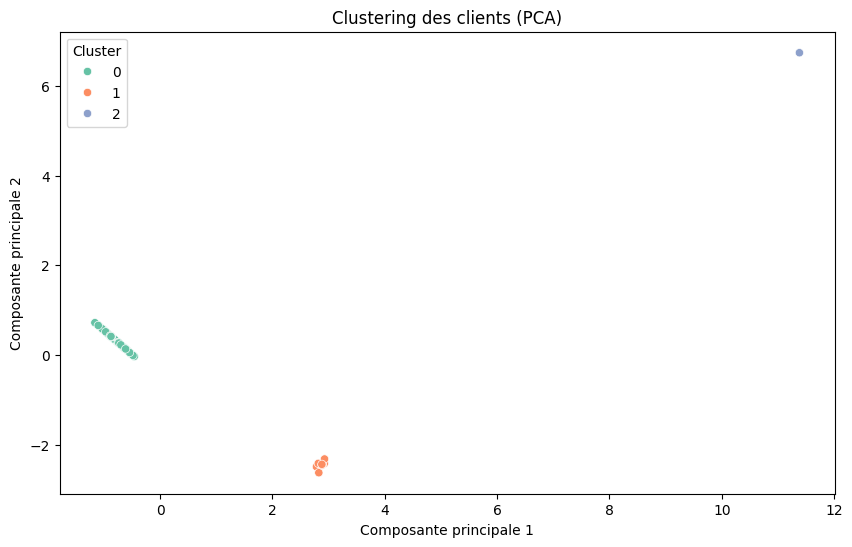

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_final, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title("Clustering des clients (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster")
plt.show()

cluster 0 : représente la majorité des clients qui a un comportement moyen ou bien faible ( faible nombre de réservations/Achats , peu de dépenses )
-> Cluster des clients Standars ou peu actifs
cluster 1 : pca 1 plus grand probablement plus de dépenses ou plus de reservations
avec un pca2 mlus faible cad moins de diversité dans les voyages
-> cluster actif mais avec une experience ou comportement spécifique
cluster 2 : pca1 et pca2 ont des valeurs grandes un seul client ou bien peu
montant total d'achat/reservation tres gros notes
-> Client VIP ou extrémes



In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering

In [21]:
# ------------------- MÉTRIQUES K-MEANS -------------------
inertie_kmeans = kmeans.inertia_
silhouette_kmeans = silhouette_score(X_scaled, df_final['cluster'])
db_index_kmeans = davies_bouldin_score(X_scaled, df_final['cluster'])

In [22]:
print("🔷 Résultats K-Means")
print(f"Inertie : {inertie_kmeans:.2f}")
print(f"Silhouette Score : {silhouette_kmeans:.3f}")
print(f"Davies-Bouldin Index : {db_index_kmeans:.3f}")


🔷 Résultats K-Means
Inertie : 4.94
Silhouette Score : 0.908
Davies-Bouldin Index : 0.066


In [23]:
# ------------------- DBSCAN -------------------
dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df_final['cluster_dbscan'] = dbscan_labels

In [24]:
# Il se peut qu'il y ait des -1 (bruit), on vérifie que le clustering est significatif
if len(set(dbscan_labels)) > 1:
    silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels)
    db_index_dbscan = davies_bouldin_score(X_scaled, dbscan_labels)
else:
    silhouette_dbscan = None
    db_index_dbscan = None

In [25]:
print("\n🔶 Résultats DBSCAN")
print(f"Nombre de clusters (hors bruit) : {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Silhouette Score : {silhouette_dbscan:.3f}" if silhouette_dbscan else "Silhouette Score : non applicable")
print(f"Davies-Bouldin Index : {db_index_dbscan:.3f}" if db_index_dbscan else "Davies-Bouldin Index : non applicable")



🔶 Résultats DBSCAN
Nombre de clusters (hors bruit) : 2
Silhouette Score : 0.908
Davies-Bouldin Index : 0.066


In [26]:
# ------------------- Agglomerative Clustering -------------------
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_scaled)
df_final['cluster_agglo'] = agglo_labels

In [27]:
silhouette_agglo = silhouette_score(X_scaled, agglo_labels)
db_index_agglo = davies_bouldin_score(X_scaled, agglo_labels)

print("\n🔸 Résultats Agglomerative Clustering")
print(f"Silhouette Score : {silhouette_agglo:.3f}")
print(f"Davies-Bouldin Index : {db_index_agglo:.3f}")


🔸 Résultats Agglomerative Clustering
Silhouette Score : 0.908
Davies-Bouldin Index : 0.066


In [28]:
results_df = pd.DataFrame({
    'Algorithme': ['KMeans', 'DBSCAN', 'Agglomerative'],
    'Silhouette Score': [silhouette_kmeans, silhouette_dbscan if silhouette_dbscan else None, silhouette_agglo],
    'Davies-Bouldin Index': [db_index_kmeans, db_index_dbscan if db_index_dbscan else None, db_index_agglo]
})

print("\n📋 Comparaison des algorithmes :")
print(results_df)



📋 Comparaison des algorithmes :
      Algorithme  Silhouette Score  Davies-Bouldin Index
0         KMeans          0.907982              0.065909
1         DBSCAN          0.907982              0.065909
2  Agglomerative          0.907982              0.065909


In [29]:
# Sélectionner les colonnes à exporter
colonnes_export = ['Client_FK', 'montant_total_achat', 'nb_achats',
                   'montant_total_reservation', 'nb_reservations',
                   'note_moyenne', 'nb_jours_voyage', 'cluster']

# Export CSV
df_final[colonnes_export].to_csv('resultats_kmeans_clients.csv', index=False)

# Télécharger dans Google Colab
files.download('resultats_kmeans_clients.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Supprimer les clients avec clé invalide (0 ou null)
df_faitAchat = df_faitAchat[df_faitAchat['Client_FK'] > 0]
df_faitReservation = df_faitReservation[df_faitReservation['ClientID_FK'] > 0]


In [31]:
# Supprimer les lignes où aucun identifiant client n'est défini
df_final = df_final[df_final['Client_FK'].notna() & (df_final['Client_FK'] > 0)]


In [32]:
df_final['Client_FK'] = df_final['Client_FK'].astype(int)


In [33]:
colonnes_export = ['Client_FK', 'montant_total_achat', 'nb_achats',
                   'montant_total_reservation', 'nb_reservations',
                   'note_moyenne', 'nb_jours_voyage', 'cluster']
df_final[colonnes_export].to_csv('resultats_kmeans_clients.csv', index=False)
files.download('resultats_kmeans_clients.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Supprimer les lignes avec Client_FK ou ClientID_FK nul ou vide
df_faitAchat = df_faitAchat[df_faitAchat['Client_FK'].notna() & (df_faitAchat['Client_FK'] > 0)]
df_faitReservation = df_faitReservation[df_faitReservation['ClientID_FK'].notna() & (df_faitReservation['ClientID_FK'] > 0)]


In [34]:
df_faitAchat['Client_FK'] = df_faitAchat['Client_FK'].astype(int)
df_faitReservation['ClientID_FK'] = df_faitReservation['ClientID_FK'].astype(int)


In [35]:
achat_stats = df_faitAchat.groupby('Client_FK').agg(
    montant_total_achat=('Prix_Total', 'sum'),
    nb_achats=('AchatID_PK', 'count')
).reset_index()

reservation_stats = df_faitReservation.groupby('ClientID_FK').agg(
    montant_total_reservation=('Total_Prix', 'sum'),
    nb_reservations=('Reservation_PK', 'count'),
    note_moyenne=('Note_Client', 'mean')
).reset_index()


In [37]:
# Fusion achat + réservation
df_final = achat_stats.merge(reservation_stats, left_on='Client_FK', right_on='ClientID_FK', how='left')

# Fusion avec nb jours de voyage
df_faitReservation = df_faitReservation.merge(df_temps, left_on='Temps_FK', right_on='TempsID')
voyage_stats = df_faitReservation.groupby('ClientID_FK').agg(
    nb_jours_voyage=('Date_Complète', 'nunique')
).reset_index()

df_final = df_final.merge(voyage_stats, on='ClientID_FK', how='left')


In [38]:
df_final.fillna({
    'montant_total_reservation': 0,
    'nb_reservations': 0,
    'note_moyenne': 0,
    'nb_jours_voyage': 0
}, inplace=True)


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Sélection des variables explicatives
features = ['montant_total_achat', 'nb_achats', 'montant_total_reservation',
            'nb_reservations', 'note_moyenne', 'nb_jours_voyage']

X = df_final[features]

# 2. Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Clustering avec KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_scaled)


In [41]:
for col in ['montant_total_reservation', 'nb_reservations', 'note_moyenne', 'nb_jours_voyage']:
    moyenne = df_final[col].mean()
    df_final[col].fillna(moyenne, inplace=True)


<ipython-input-41-5eafe72655dd>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final[col].fillna(moyenne, inplace=True)


In [42]:
# Optionnel : ne garder que les colonnes utiles
colonnes_export = ['Client_FK'] + features + ['cluster']
df_final[colonnes_export].to_csv('resultats_kmeans_clients.csv', index=False)
